In [32]:
import subprocess, msprime, pyslim, tskit, os, matplotlib, pickle, random, dadi
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcol
import numpy as np
import pandas as pd
import dadi.DFE as DFE
from dadi.DFE import *
from scipy import stats
from dadi import *
from scipy.stats import norm

In [2]:
os.chdir('/project2/jnovembre/ccliu/backgroundSelection')

## Hypothesis 1
### The presence of background selection biases estimates of $\gamma$, towards more negative values.

The effect of BGS is often approximated with reduction in population sizes. However, BGS also distorts the shape at the ends of allele frequency spectrum (Cvijovic 2018). This distortion biases estimates of $\gamma$. This bias is stronger with larger sample size because we are sampling more rare alleles. In this notebook we verify this hypothesis with simulations.

## Simulation set-up

We simulate constant-sized populations (N = 5000, diploid) under BGS from SLiM, and each genome is of length $l = 500kb$. There are three classes of mutations with ratio 4 to 1 to 20.
1. Deleterious mutations with s=-0.1 generating background selection (16%)
2. Weakly deleterious mutations with s=-0.02 (and a lower mutation rate) for inferring $\gamma$ (4%)
3. Nuetral mutation (80%)  

The total mutation rate is set to $\mu = 6.25 \times 10^{-7}$.  

We are ignoring BGS generated from the second mutation class. The first mutation class generates BGS of approximately strength $B = e^{2U_d / s}$ (The factor 2 here is due to paramatrization of SLiM: 1, h(1+sh), 1+s, compared to the more oftenly used 1, 1-2hs, 1-2s), where $U_d = \mu \times 4/25 \times l$.



In [3]:
N = 5000
mu = 6.25 * 1e-7
l = 5e5
Ud = mu * l * 4/25

s = -0.1
B = np.exp(Ud / s * 2)
print(f'B =  {B}')
print(f'Ne x s =  {- N * B * s}')

B =  0.36787944117144233
Ne x s =  183.93972058572118


### Varying sample size
Here we are showing that the negative bias of inferred $\gamma$ increases with larger sample size. We use $\partial a \partial i$ for inference. Below are paramatrization of fitness. 
 - $\partial a \partial i$: 1, 1+2sh, and 1+2s  
 - SLiM: 1, h(1+sh), 1+s  

We simulate 100 replicates and for each replicate we resample 10-500 individuals to form sample frequency spectrum, which is fed into the $\partial a \partial i$ framework

In [17]:
# functions for obtaining SFS from ts files
def allele_counts(ts, sample_sets=None):
    if sample_sets is None:
        sample_sets = [ts.samples()]
    def f(x):
        return x
    return ts.sample_count_stat(sample_sets, f, len(sample_sets),
               span_normalise=False, windows='sites',
               polarised=True, mode='site', strict=False)


def get_del_afss(ts_file, sample_size = None):
    if sample_size:
        ts = pyslim.load(ts_file).simplify()
        keep_indivs = np.random.choice(ts.individuals_alive_at(0), 
                                       sample_size, replace=False)
        keep_nodes = []
        for i in keep_indivs:
            keep_nodes.extend(ts.individual(i).nodes)
        ts = ts.simplify(keep_nodes)

    mut_type = np.zeros(ts.num_sites)
    for j, s in enumerate(ts.sites()):
        mt = []
        for m in s.mutations:
            for md in m.metadata:
                mt.append(md.mutation_type)
        if len(set(mt)) > 1:
            mut_type[j] = 4
        else:
            mut_type[j] = mt[0]

    freqs = allele_counts(ts)
    l = len(ts.samples())
    freqs = freqs.flatten().astype(int)
    mut_afs = np.zeros((l + 1, 4), dtype='int64')
    for k in range(4):
        mut_afs[:, k] = np.bincount(freqs[mut_type == k+1], 
                                    minlength=l + 1)
    
    return mut_afs[:(2 * sample_size) + 1, 2]


# demographic models for dadi
def constant_size(params, ns, pts):
    gamma = params[0]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx, gamma=gamma)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

# dfe for fixed gamma
def normal2(xx, mu):
    '''
    normal distribution for inferring fixed gamma
    '''
    return norm.pdf(xx, loc=mu, scale=2.5)

def infer_gamma_from_ts(file_temp, spectra_temp, theta_ns=250., var='sample_size', max_cutoff=0):
    '''
    file: afs file template string
    spectra: dadi cached spectra file template string
    max_cut: maximum value for SFS truncation
    '''
    
    assert var in ['sample_size', 'threshold']
    
    res = []
    if var == 'sample_size':
        for i in range(1, 21):
            for s in range(5, 51, 5):
                del_afs = get_del_afss(file_temp.format(i), sample_size = s)

                spectra = pickle.load(open(spectra_temp.format(int(2 * s)),'rb'))
                data = dadi.Spectrum(del_afs)

                sel_params = [20.]
                lower_bound, upper_bound = [1], [300.]
                p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                              upper_bound=upper_bound)
                popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                                  func_args=[normal2, theta_ns],
                                                  lower_bound=lower_bound, upper_bound=upper_bound, 
                                                  verbose=0, maxiter=100, multinom=False)[0]
                res.append((s, popt))
                
    elif var == 'threshold':
        s = 460
        for i in range(1, 6):
            for m in range(1, max_cutoff + 1):
                del_afs = get_del_afss(file_temp.format(i), sample_size = s)

                spectra = pickle.load(open(spectra_temp.format(2 * s),'rb'))
                data = dadi.Spectrum(del_afs)
                data.mask[:(m + 1)] = True
                data.mask[-(m + 1):] = True

                sel_params = [150.]
                lower_bound, upper_bound = [1], [300.]
                p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                              upper_bound=upper_bound)
                popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                                  func_args=[normal2, theta_ns],
                                                  lower_bound=lower_bound, upper_bound=upper_bound, 
                                                  verbose=0, maxiter=100, multinom=False)[0]
                res.append((m, popt))
                
        
        
    return res



In [38]:

def infer_gamma_from_ts(file_temp, spectra_temp, theta_ns=250., var='sample_size', max_cutoff=0):
    '''
    file: afs file template string
    spectra: dadi cached spectra file template string
    max_cut: maximum value for SFS truncation
    '''
    
    assert var in ['sample_size', 'threshold']
    
    res = []
    if var == 'sample_size':
        for i in range(1, 101):
            for s in range(10, 411, 400):
                del_afs = get_del_afss(file_temp.format(i), sample_size = s)

                spectra = pickle.load(open(spectra_temp.format(int(2 * s)),'rb'))
                data = dadi.Spectrum(del_afs)

                sel_params = [20.]
                lower_bound, upper_bound = [1], [300.]
                p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                              upper_bound=upper_bound)
                popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                                  func_args=[normal2, theta_ns],
                                                  lower_bound=lower_bound, upper_bound=upper_bound, 
                                                  verbose=0, maxiter=100, multinom=False)[0]
                res.append((s, popt))
                
    elif var == 'threshold':
        s = 85
        for i in range(1, 6):
            for m in range(1, max_cutoff + 1):
                del_afs = get_del_afss(file_temp.format(i), sample_size = s)

                spectra = pickle.load(open(spectra_temp.format(2 * s),'rb'))
                data = dadi.Spectrum(del_afs)
                data.mask[:(m + 1)] = True
                data.mask[-(m + 1):] = True

                sel_params = [150.]
                lower_bound, upper_bound = [1], [300.]
                p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                              upper_bound=upper_bound)
                popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                                  func_args=[normal2, theta_ns],
                                                  lower_bound=lower_bound, upper_bound=upper_bound, 
                                                  verbose=0, maxiter=100, multinom=False)[0]
                res.append((m, popt))
                
        
        
    return res

In [5]:
theta = round(4 * N * mu * l * 1/25)
theta

250

Here is an example $\partial d a \partial d i$'s MLE inference. I'm plotting the likelihood surface.

In [56]:
i = 1 # rep1
s = 460 # n = 420

spectra_temp = 'output/constant_spectra_theta250_n{}.bpkl'
spectra = pickle.load(open(spectra_temp.format(2 * s),'rb'))

file_temp = 'data/slim/bgs_3classes/bgs_3classes_N5000_rep{}.trees'
del_afs = get_del_afss(file_temp.format(i), sample_size = s)
data = dadi.Spectrum(del_afs)

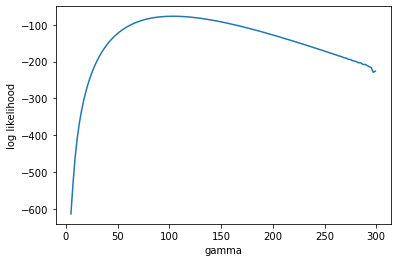

In [57]:
alphas = range(5, 300, 2)
res = []
for a in alphas:
    model_sfs = spectra.integrate([a], None, normal2, theta, None)
    ll = dadi.Inference.ll(model_sfs, data)
    res.append((a,ll))
res = list(zip(*res))
plt.plot(res[0], res[1], '-')
plt.xlabel("gamma")
plt.ylabel("log likelihood")
plt.show()

Now we infer $\gamma$ with increasing sample sizes, from 10 to 500 (diploid) individuals.

In [ ]:
file_temp = 'data/slim/bgs_3classes/bgs_3classes_N5000_rep{}.trees'
spectra_temp = 'output/constant_spectra_theta250_n{}.bpkl'
res = infer_gamma_from_ts(file_temp=file_temp, spectra_temp=spectra_temp, theta_ns=250)
res_df = pd.DataFrame(res, columns =['sample_size', 'gamma']) 

In [34]:
res_df.groupby(['sample_size']).mean()

,gamma
sample_size,
10,111.180893
410,105.421037


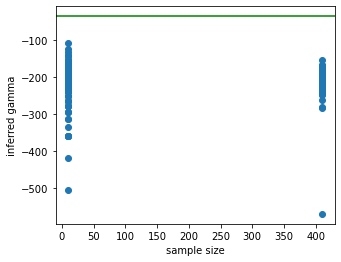

In [28]:
s = -0.02
plt.figure(figsize=(5, 4))
plt.scatter([r[0] for r in res], [-2 * r[1] for r in res])
plt.xlabel("sample size")
plt.ylabel("inferred gamma")
plt.axhline(y = N * s * B , color='g', linestyle='-')
plt.show()

In [41]:
file = 'data/slim/bgs_3classes/bgs_3classes_N5000_rep{}.trees'
spectra = 'output/constant_spectra_theta250_n{}.bpkl'
res = infer_gamma_from_ts(file_temp=file, spectra_temp=spectra, theta_ns=250, var='threshold', max_cutoff=15)

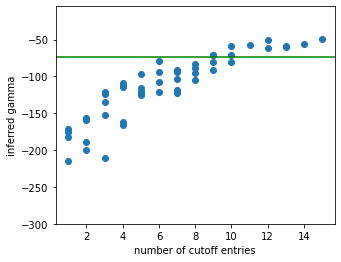

In [42]:
s = -0.02
plt.figure(figsize=(5, 4))
plt.scatter([r[0] for r in res], [-2 * r[1] for r in res])
plt.xlabel("number of cutoff entries")
plt.ylabel("inferred gamma")
plt.ylim(-300, -5)
plt.axhline(y = 2 * N * s * B , color='g', linestyle='-')
plt.show()

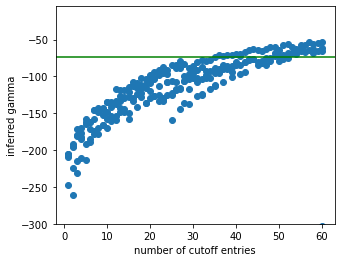

In [70]:
s = -0.02
plt.figure(figsize=(5, 4))
plt.scatter([r[0] for r in res], [-2 * r[1] for r in res])
plt.xlabel("number of cutoff entries")
plt.ylabel("inferred gamma")
plt.ylim(-300, -5)
plt.axhline(y = 2 * N * s * B , color='g', linestyle='-')
plt.show()